In [1]:
from glob import glob
import os

root = './datasets/rice_leaf_diseases_dataset/original'

directories =  glob(os.path.join(root, '*'))
directory_names = []


for directory in directories:
    directory_names.append(directory[directory.rindex('\\') + 1:])

print(directory_names)

['Bacterialblight', 'Brownspot', 'Leafsmut']


In [ ]:
root = './datasets/rice_leaf_diseases_dataset/original/'


for name in directory_names:
    for i, file_name in enumerate(os.listdir(os.path.join(root, name))):
        old_file = os.path.join(root + name + '/', file_name)
        new_file = os.path.join(root + name + '/', name+str(i+1)+'.png')

    os.rename(old_file,new_file)

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

BATCH_SIZE = 64

image_generator = ImageDataGenerator(rescale = 1./255)

generator = image_generator.flow_from_directory(root, target_size=(244,244), batch_size=BATCH_SIZE, class_mode='categorical')
print(generator.class_indices)

Found 4684 images belonging to 3 classes.
{'Bacterialblight': 0, 'Brownspot': 1, 'Leafsmut': 2}


In [5]:
target_name = {v: k for k, v in generator.class_indices.items()}
target_name

{0: 'Bacterialblight', 1: 'Brownspot', 2: 'Leafsmut'}

In [6]:
target_names = []
for target in generator.classes:
    target_names.append(target_name[target])

In [7]:
import pandas as pd

rice_df = pd.DataFrame({'file_paths': generator.filepaths, 'target_names': target_names, 'targets': generator.classes})
rice_df.file_paths = rice_df.file_paths.apply(lambda file_path: file_path.replace('\\', '/'))
rice_df

,file_paths,target_names,targets
0,./datasets/rice_leaf_diseases_dataset/original...,Bacterialblight,0
1,./datasets/rice_leaf_diseases_dataset/original...,Bacterialblight,0
2,./datasets/rice_leaf_diseases_dataset/original...,Bacterialblight,0
3,./datasets/rice_leaf_diseases_dataset/original...,Bacterialblight,0
4,./datasets/rice_leaf_diseases_dataset/original...,Bacterialblight,0
...,...,...,...
4679,./datasets/rice_leaf_diseases_dataset/original...,Leafsmut,2
4680,./datasets/rice_leaf_diseases_dataset/original...,Leafsmut,2
4681,./datasets/rice_leaf_diseases_dataset/original...,Leafsmut,2
4682,./datasets/rice_leaf_diseases_dataset/original...,Leafsmut,2


In [9]:
from sklearn.model_selection import train_test_split

train_images, test_images, train_targets, test_targets = \
train_test_split(rice_df.file_paths, 
                 rice_df.targets, 
                 stratify=rice_df.targets, 
                 test_size=0.2, random_state=124)

print(train_targets.value_counts())
print(test_targets.value_counts())

targets
1    1296
0    1283
2    1168
Name: count, dtype: int64
targets
1    324
0    321
2    292
Name: count, dtype: int64


In [10]:
from sklearn.model_selection import train_test_split

train_images, validation_images, train_targets, validation_targets = \
train_test_split(train_images, 
                 train_targets, 
                 stratify=train_targets, 
                 test_size=0.2, random_state=124)

print(train_targets.value_counts())
print(validation_targets.value_counts())
print(test_targets.value_counts())

targets
1    1037
0    1026
2     934
Name: count, dtype: int64
targets
1    259
0    257
2    234
Name: count, dtype: int64
targets
1    324
0    321
2    292
Name: count, dtype: int64


In [11]:
train_df = rice_df.iloc[train_images.index].reset_index(drop=True)
validation_df = rice_df.iloc[validation_images.index].reset_index(drop=True)
test_df = rice_df.iloc[test_images.index].reset_index(drop=True)

print(train_df.shape)
print(validation_df.shape)
print(test_df.shape)

(2997, 3)
(750, 3)
(937, 3)


In [12]:
import numpy as np
from tensorflow.keras.utils import Sequence
from sklearn.utils import shuffle
import cv2

IMAGE_SIZE = 64
BATCH_SIZE = 64

class Dataset(Sequence):

    # 생성자 초기화 (train에만 augmentation과 shuffle 적용)
    def __init__(self, file_paths, targets, batch_size=BATCH_SIZE, aug=None, preprocess=None, shuffle=False):
        self.file_paths = file_paths
        self.targets = targets
        self.batch_size = batch_size
        self.aug = aug
        self.preprocess = preprocess
        self.shuffle = shuffle
        
        if self.shuffle:
            # 에포크 종료 시, 객체 생성 및 데이터 섞기
            self.on_epoch_end()

    # __len__()는 전체 데이터 건수에서 batch_size 단위로 나눈 데이터 수
    # 예를 들어, 1000개의 데이터를 30 batch_size로 설정하면, 1 batch당 33.33..개이다.
    # 이 때, 소수점은 무조건 올려서 33 + 1 = 34개로 설정한다.
    def __len__(self):
        # 길이가 실수면 오류가 나므로 정수로 변환 필수
        return int(np.ceil(len(self.targets) / self.batch_size))

    # batch_size 단위로 이미지 배열과 타켓 데이터들을 가져온 뒤 변환한 값을 리턴한다.
    def __getitem__(self, index):

        # 각 배치 사이즈를 구하는 공식은 아래와 같다.
        # (시작 배치 인덱스 * 배치 사이즈) : (다음 배치 인덱스 * 배치사이즈)

        # image 와 target의 bath
        file_paths_batch = self.file_paths[index * self.batch_size: (index + 1) * self.batch_size]
        targets_batch = self.targets[index * self.batch_size: (index + 1) * self.batch_size]

        # np zeros로 초기화
        # result_batch 를 4차원으로 선언
        results_batch = np.zeros((file_paths_batch.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))

        # 반복문을 통해 각 이미지에 augmentation 혹은 preprocessing을 적용
        # 적용된 이미지를 result_batch에 인덱스에 담아준 후 결과로 리턴
        # range는 row 즉 데이터의 양만큼
        for i in range(file_paths_batch.shape[0]):
            image = cv2.cvtColor(cv2.imread(file_paths_batch[i]), cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))

            if self.aug is not None:
                image = self.aug(image=image)['image']

            if self.preprocess is not None:
                image = self.preprocess(image)
                    
            results_batch[i] = image

        return results_batch, targets_batch

    # 각 에포크가 실행 될때마다 shuffle이 True일 결우
    # 각 image와 타겟의 짝을 맞추어 섞어 준다.
    def on_epoch_end(self):
        if self.shuffle:
            self.file_paths, self.targets = shuffle(self.file_paths, self.targets)        

In [21]:
import albumentations as A
from tensorflow.keras.applications.xception import preprocess_input as xception_preprocess_input

train_file_paths = train_df['file_paths'].values
# train_targets = train_df['targets'].values # SparseCategoricalCrossEntropy
train_targets = pd.get_dummies(train_df['targets']).values # CategoricalCrossEntropy

validation_file_paths = validation_df['file_paths'].values
# validation_targets = validation_df['targets'].values # SparseCategoricalCrossEntropy
validation_targets = pd.get_dummies(validation_df['targets']).values # CategoricalCrossEntropy

test_file_paths = test_df['file_paths'].values
# test_targets = test_df['targets'].values # SparseCategoricalCrossEntropy
test_targets = pd.get_dummies(test_df['targets']).values # CategoricalCrossEntropy

aug = A.Compose([
    A.ShiftScaleRotate(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0, p=0.5)
])

train_dataset = Dataset(train_file_paths, 
                        train_targets, 
                        batch_size=BATCH_SIZE, 
                        aug=aug, 
                        preprocess=xception_preprocess_input, 
                        shuffle=True)

validation_dataset = Dataset(validation_file_paths, 
                        validation_targets, 
                        batch_size=BATCH_SIZE, 
                        preprocess=xception_preprocess_input)

test_dataset = Dataset(test_file_paths, 
                        test_targets, 
                        batch_size=BATCH_SIZE, 
                        preprocess=xception_preprocess_input)

In [29]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense , Conv2D , Dropout , Flatten , Activation, MaxPooling2D , GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import MobileNetV2

def create_model(model_name='vgg16', verbose=False):
    input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    if model_name == 'vgg16':
        model = VGG16(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'resnet50': # ResNet50, 74.9% ; ResNet50V2, 76.0%
        model = ResNet50V2(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'xception': # Inception을 기초로 한 모델
        model = Xception(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'mobilenet':
        model = MobileNetV2(input_tensor=input_tensor, include_top=False, weights='imagenet')

    x = model.output

    # 분류기
    x = GlobalAveragePooling2D()(x)
    if model_name != 'vgg16':
        x = Dropout(rate=0.5)(x)
    x = Dense(50, activation='relu')(x)
    if model_name != 'vgg16':
        x = Dropout(rate=0.5)(x)
    output = Dense(3, activation='softmax', name='output')(x)
    
    model = Model(inputs=input_tensor, outputs=output)
    
    if verbose:
        model.summary()
    
    return model

In [30]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Accuracy

model = create_model(model_name='mobilenet', verbose=True)
# model.compile(optimizer=Adam(), loss=SparseCategoricalCrossentropy(), metrics=['acc'])
model.compile(optimizer=Adam(), loss=CategoricalCrossentropy(), metrics=['acc'])

C:\Users\user\AppData\Local\Temp\ipykernel_23936\433207055.py:19: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  model = MobileNetV2(input_tensor=input_tensor, include_top=False, weights='imagenet')


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)    │ (None, 64, 64, 3)         │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1 (Conv2D)                │ (None, 32, 32, 32)        │             864 │ input_layer_4[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn_Conv1 (BatchNormalization) │ (None, 32, 32, 32)        │             128 │ Conv1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1_relu (ReLU)             │ (None, 32, 32, 32)        │               0 │ bn_Conv1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise       │ (None, 32, 32, 32)        │             288 │ Conv1_relu[0][0]           │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_BN    │ (None, 32, 32, 32)        │             128 │ expanded_conv_depthwise[0… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_relu  │ (None, 32, 32, 32)        │               0 │ expanded_conv_depthwise_B… │
│ (ReLU)                        │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project         │ (None, 32, 32, 16)        │             512 │ expanded_conv_depthwise_r… │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project_BN      │ (None, 32, 32, 16)        │              64 │ expanded_conv_project[0][… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand (Conv2D)       │ (None, 32, 32, 96)        │           1,536 │ expanded_conv_project_BN[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_BN             │ (None, 32, 32, 96)        │             384 │ block_1_expand[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_relu (ReLU)    │ (None, 32, 32, 96)        │               0 │ block_1_expand_BN[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_pad (ZeroPadding2D)   │ (None, 33, 33, 96)        │               0 │ block_1_expand_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_depthwise             │ (None, 16, 16, 96)        │             864 │ block_1_pad[0][0]          │
│ (DepthwiseConv2D)             │                           │               

 Total params: 2,322,187 (8.86 MB)

 Trainable params: 2,288,075 (8.73 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [31]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

mcp_cb = ModelCheckpoint(
    filepath="./callback_files/weights.{epoch:03d}-{val_loss:.4f}-{acc:.4f}.weights.h5",
    monitor='val_loss',
    save_best_only=False,
    save_weights_only=True,
    mode='min'
)

rlr_cb = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=2,
    mode='min'
)

ely_cb = EarlyStopping(
    monitor='val_loss',
    patience=4,
    mode='min'
)

In [32]:
N_EPOCHS = 10

history = model.fit(train_dataset,
                    batch_size=BATCH_SIZE,
                    epochs=N_EPOCHS, 
                    validation_data=validation_dataset,
                    callbacks=[mcp_cb, rlr_cb, ely_cb])

Epoch 1/10


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


47/47 ━━━━━━━━━━━━━━━━━━━━ 42s 520ms/step - acc: 0.5331 - loss: 1.3002 - val_acc: 0.6107 - val_loss: 2.6709 - learning_rate: 0.0010
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 11s 224ms/step - acc: 0.8199 - loss: 0.4448 - val_acc: 0.7787 - val_loss: 2.2133 - learning_rate: 0.0010
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 11s 221ms/step - acc: 0.9049 - loss: 0.2883 - val_acc: 0.8667 - val_loss: 1.0700 - learning_rate: 0.0010
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 11s 219ms/step - acc: 0.9367 - loss: 0.1800 - val_acc: 0.8280 - val_loss: 2.3392 - learning_rate: 0.0010
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 11s 224ms/step - acc: 0.9650 - loss: 0.0968 - val_acc: 0.8853 - val_loss: 1.4976 - learning_rate: 0.0010
Epoch 6/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 12s 246ms/step - acc: 0.9727 - loss: 0.0798 - val_acc: 0.9213 - val_loss: 1.1360 - learning_rate: 1.0000e-04
Epoch 7/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 11s 233ms/step - acc: 0.9853 - loss: 0.0569 - val_acc: 0.9360 - val_loss: 0.9032 - learning_rate: 1.0000e-04
Ep

In [34]:
model.evaluate(test_dataset)

 1/15 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - acc: 0.9062 - loss: 0.8018

C:\ProgramData\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 334ms/step - acc: 0.9425 - loss: 0.8515


[0.8683509230613708, 0.948772668838501]

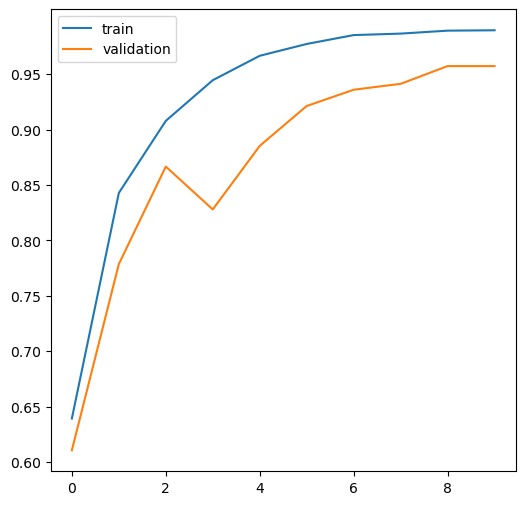

In [35]:
import matplotlib.pyplot as plt

def show_history(history):
    plt.figure(figsize=(6, 6))
    plt.yticks(np.arange(0, 1, 0.05))
    plt.plot(history.history['acc'], label='train')
    plt.plot(history.history['val_acc'], label='validation')
    plt.legend()
    
show_history(history)